# Detekcija i klasifikacija malicioznih Android aplikacija


> Detaljan pregleda kako sam razmisljala i implementirala stvari kroz vreme mozete videti u [TODO.md](TODO.md) fajlu 

## Uvod
Zbog čestih i novih izmena zakona kao što je DMA (Digital Markets Act), se povećava rizik da korisnik nesvesno dođe u interakciju sa malicioznim Android aplikacijama. 
Detekcija ovih aplikacija često zahteva puno resursa, ali korišćenjem mašinske inteligencije, ovi 
resursi i vreme potrebno za ovakvu evaluaciju može biti značajno smanjeno.

Cilj ovog projekta je detekcija malicioznih Android aplikacija i njihova klasifikacija u jednu od 36 malicioznih familija, 
korišćenjem kombinacije statičkih i dinamičkih karakteristika.  

## Skup podataka
Ovaj projekat koristi skup podataka sa GitHub repozitorijuma [Kronodroid](https://github.com/aleguma/kronodroid). Nema nikakvog predprocesiranja ovih podataka pre pokretanja koda. Korišćeni su skupovi podataka [real_legitimate_v1](data\raw\real_legitimate_v1.csv) i [real_malware_v1](data\raw\real_malware_v1.csv) koji se nalaze na u [Kronodroid-u](https://github.com/aleguma/kronodroid) u folderu [real_device](https://github.com/aleguma/kronodroid/tree/main/real_device).

### Analiza skupa podataka
Skup podataka sadrzi podeljene .csv fajlove za maliciozne i benigne aplikacije. 

In [1]:
from data_processing import show_data_info
show_data_info()

-----------LEGIT DATASET-----------
                                      Package  Malware  execve  getuid32  \
0                        outside.walljul01e\n        0       0        35   
1                    org.developerworks.ifp\n        0       0        22   
2                    zen.meditation.android\n        0       0        59   
3  com.kauf.jokes.account1.FunnyAnimalJokes\n        0       0         9   
4                         com.genwi.myalias\n        0       0        24   

   getgid32  geteuid32  getegid32  getresuid32  getresgid32  readahead  ...  \
0         0          0          0            0            0          0  ...   
1         0          0          0            0            0          0  ...   
2         0          0          0            0            0          0  ...   
3         0          0          0            0            0          0  ...   
4         0          0          0            0            0          0  ...   

   NrIntServicesActions  NrIntAc

Ukupno imamo 484 kolona i 78,137 redova.

#### Kolone
Skup podataka ima ukupno 484 kolone. Većina statičkih podataka su binarni (nule i jedinice), dok je većina dimaničkih podataka numerički. Ciljna kolona u klasifikaciji `MalFamily`je textualnog tipa. 

In [2]:
# Detaljan ispis kolona
from data_processing import print_columns
print_columns()

Malware, getuid32, getgid32, geteuid32, getegid32, getgroups32, getppid, brk, kill, tgkill, ptrace, getpriority, setpriority, setrlimit, prctl, sigaltstack, read, write, close, getpid, munmap, mremap, msync, mprotect, madvise, mlock, munlock, mincore, ioctl, writev, fcntl64, flock, fchmod, dup, fsync, fdatasync, getdents64, lseek, _llseek, ftruncate64, sendfile64, truncate, mmap2, fstatfs64, statfs64, fstat64, chdir, getcwd, setxattr, times, nanosleep, clock_getres, setitimer, timer_create, timer_settime, sigaction, rt_sigaction, rt_sigprocmask, rt_sigsuspend, socket, bind, connect, listen, getsockname, socketpair, recvfrom, shutdown, setsockopt, getsockopt, sendmsg, sched_setscheduler, sched_getscheduler, sched_yield, sched_getparam, sched_get_priority_max, sched_get_priority_min, sched_setaffinity, sched_getaffinity, uname, umask, sysinfo, epoll_ctl, exit_group, wait4, clock_gettime, gettimeofday, clone, futex, vfork, rt_sigreturn, restart_syscall, gettid, epoll_wait, stat64, pipe, p

Ciljne kolone su: `Malware` (0 ili 1) i `MalFamily` (textualni naziv familije) <br><br>

Statičke kolone: <br>
- `SYS_300, SYS_301, SYS_302...` predstavljaju koje sistemske pozive aplikacija može da poziva.  <br>
- `ACCESS_MEDIA_LOCATION,ACCESS_NETWORK_STATE...` predstavljaju dozvole (permisije) aplikacije. <br>
- `signature, TimesSubmitte i NrContactedIps` nisu od koristi za naš model pa ih odmah uklanjamo. 
- `Scanners i Detection_Ratio` su posledica kako je pravljen ovaj skup podataka i sadrže metapodatke, tako da <bold>moraju</bold> biti uklonjeni.<br>
- `NrIntReceivers, TotalIntentFilters, nr_permissions...` predstavljaju broj dozvola. <br>

Dinamičke kolone: <br>
- `execve, getuid32, getgid32...` predstavljaju Linux sistemske pozive koje aplikacija pokreće. Vrednosti ovih polja su brojevi poziva.

## Predprocesiranje podataka


Predprocesiranje podataka se vrši u fajlu [data_processing](data_processing.py).

Funkcija `refine_data` kombinuje oba skupa podataka u jedan, a zatim izbaci sve redove i kolone koji su u potpunosti prazni. <br>

Posle toga se vrši ispis redova i kolona koji imaju bar jednu NaN vrednost. <br>
Pošto je nađeno tačno 642 kolona sa praznim vrednostima i tačno 642 redova sa tačnim vrednostima, možemo zaključiti da samo ti redovi imaju NaN vrednosti u tim kolonama i ukloniti te redove. <br>
Ovi redovi čine `0.8%` od svih redova. 

Posle toga se koriste fajlovi u [headers](headers) folderu kako bi se podeli spojeni skup podataka na skup za binarni i skup za klasifikacioni model. Ovi skupovi se čuvaju u folderu [data/refined](data/refined/).

In [3]:
from data_processing import refine_data
refine_data()

-----------COMBINED DATASET-----------
                                      Package  Malware  execve  getuid32  \
0                        outside.walljul01e\n        0       0        35   
1                    org.developerworks.ifp\n        0       0        22   
2                    zen.meditation.android\n        0       0        59   
3  com.kauf.jokes.account1.FunnyAnimalJokes\n        0       0         9   
4                         com.genwi.myalias\n        0       0        24   

   getgid32  geteuid32  getegid32  getresuid32  getresgid32  readahead  ...  \
0         0          0          0            0            0          0  ...   
1         0          0          0            0            0          0  ...   
2         0          0          0            0            0          0  ...   
3         0          0          0            0            0          0  ...   
4         0          0          0            0            0          0  ...   

   NrIntServicesActions  NrIn

Takodje su izbačene sve kolone koje sadrže samo nule ili samo jedinice.

## Modeli
Postoje 2 modela u ovom projeku: model koji vrši binarnu klasifikaciju i model koji vrši klasifikaciju po malicioznim familijama. <br>
Radi lakšeg dokumentovanja, modele sam nazvala `Fly` (binarni) i `Dragon` (klasifikacioni). Zajedno se ova dva modela zovu `Dragonfly`.


### Ideja
Ideja ovog projekta je da `Fly` (binarni) model prvo odluči da li je aplikacija maliciozna ili nije. Ako jeste, on šalje tu aplikaciju dalje `Dragon` (klasifikacionom) modelu.

[Dragon](classification_model.py) model je treniran nad skupom podataka koji sadrži i statičke i dinamičke podatke, ali imas samo maliciozne aplikacije. 


[Fly](binary_model.py) model je treniran nad skupom podataka koji sadrži samo statičke podatke, ali ima i malicione i benigne aplikacije. 

### Primer koda - testiranje pretreniranih modela za binarnu klasifikaciju


Malware
1    40850
0    36480
Name: count, dtype: int64
Correlation with Malware:
READ_PHONE_STATE             0.659059
ACCESS_WIFI_STATE            0.525105
SEND_SMS                     0.492807
total_perm                   0.489451
RECEIVE_BOOT_COMPLETED       0.454598
                               ...   
UNINSTALL_SHORTCUT           0.002442
READ_SYNC_STATS              0.001390
SYS_318                      0.001196
SYS_341                      0.000230
INSTALL_LOCATION_PROVIDER    0.000200
Name: Malware, Length: 192, dtype: float64


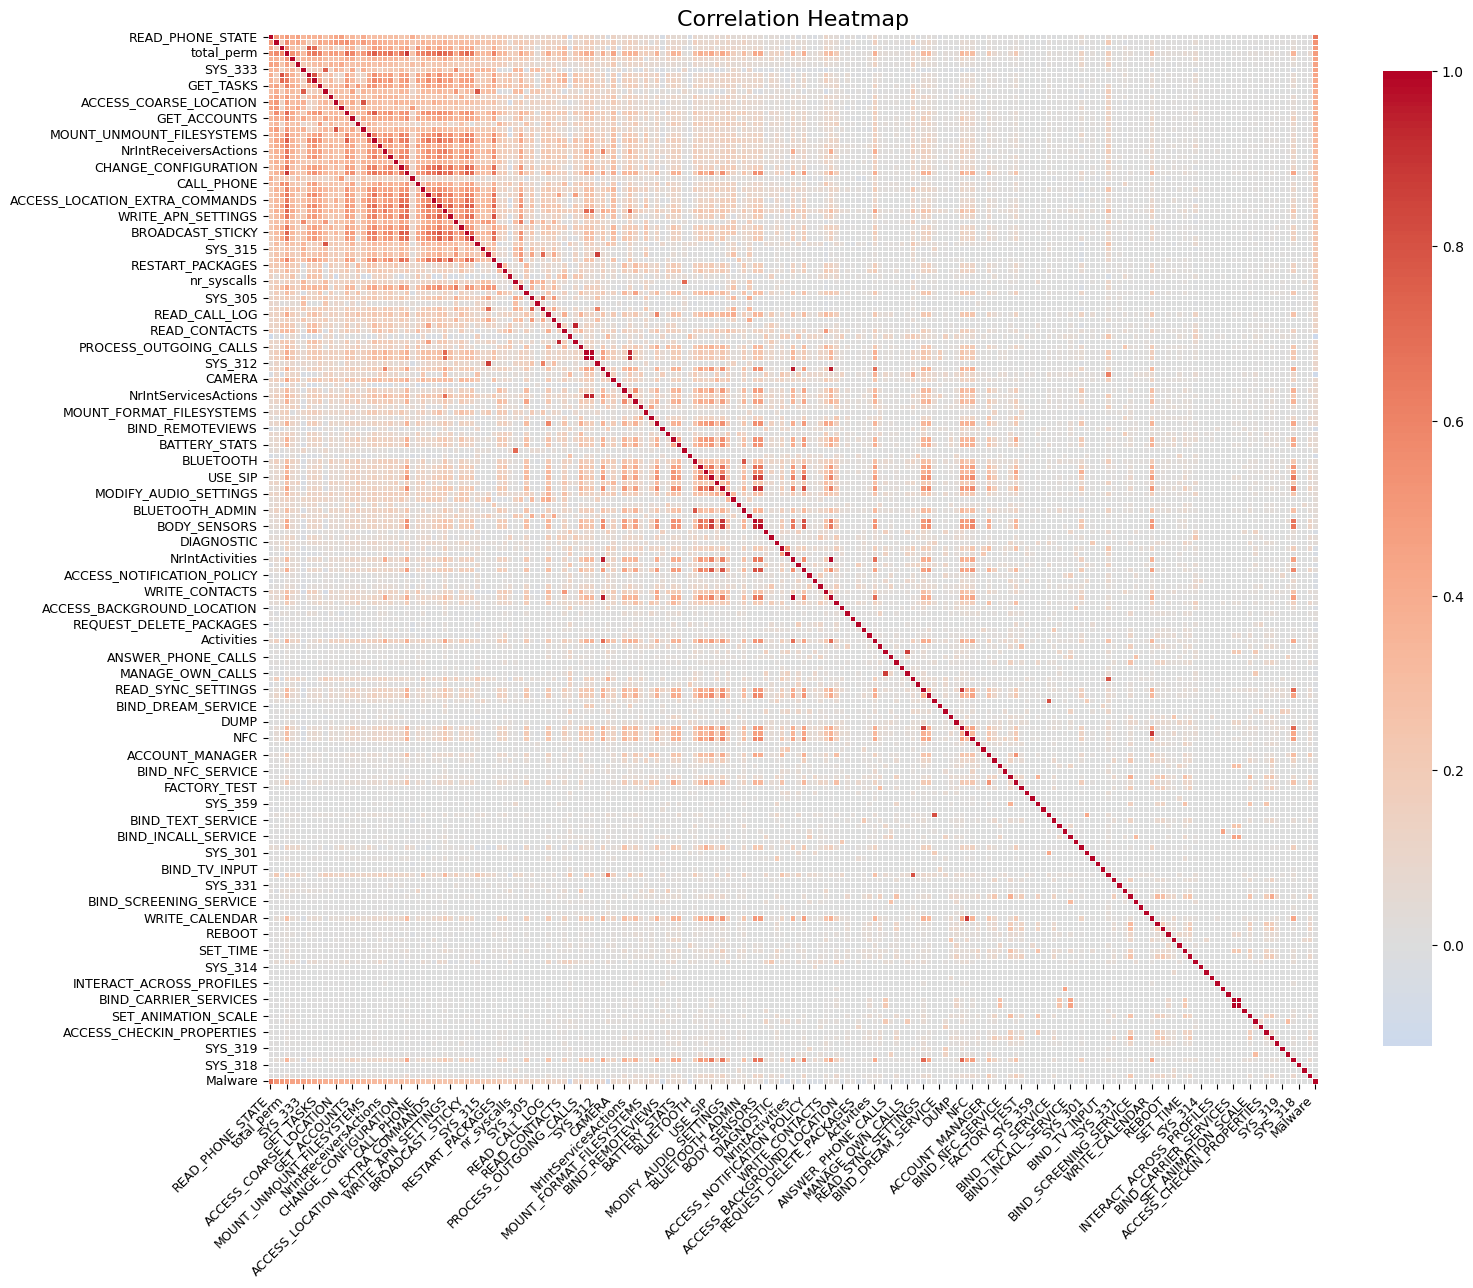


Removing 16 highly correlated features (threshold=0.8):
['SYS_312', 'SYS_343', 'BIND_MIDI_DEVICE_SERVICE', 'MANAGE_OWN_CALLS', 'RECEIVE_SMS', 'SEND_RESPOND_VIA_MESSAGE', 'SET_TIME_ZONE', 'TRANSMIT_IR', 'USE_SIP', 'WRITE_CALENDAR', 'WRITE_SYNC_SETTINGS', 'NrIntServicesActions', 'NrIntActivitiesActions', 'NrIntReceivers', 'TotalIntentFilters', 'total_perm']
Remaining features: 176
Training set size: 54131 apps
Feature threshold: 232 apps (0.43% margin of error)
Binary cols dropped: 68
Numeric cols dropped: 1
Total num of features dropped: 69
New shape: (54131, 107)
Correlation with Malware:
READ_PHONE_STATE          0.659290
ACCESS_WIFI_STATE         0.524649
SEND_SMS                  0.492557
RECEIVE_BOOT_COMPLETED    0.455138
WRITE_EXTERNAL_STORAGE    0.454777
                            ...   
SYS_328                   0.004548
SYS_331                   0.004394
READ_SYNC_STATS           0.003752
SYS_318                   0.001703
SYS_319                   0.001280
Name: Malware, Len

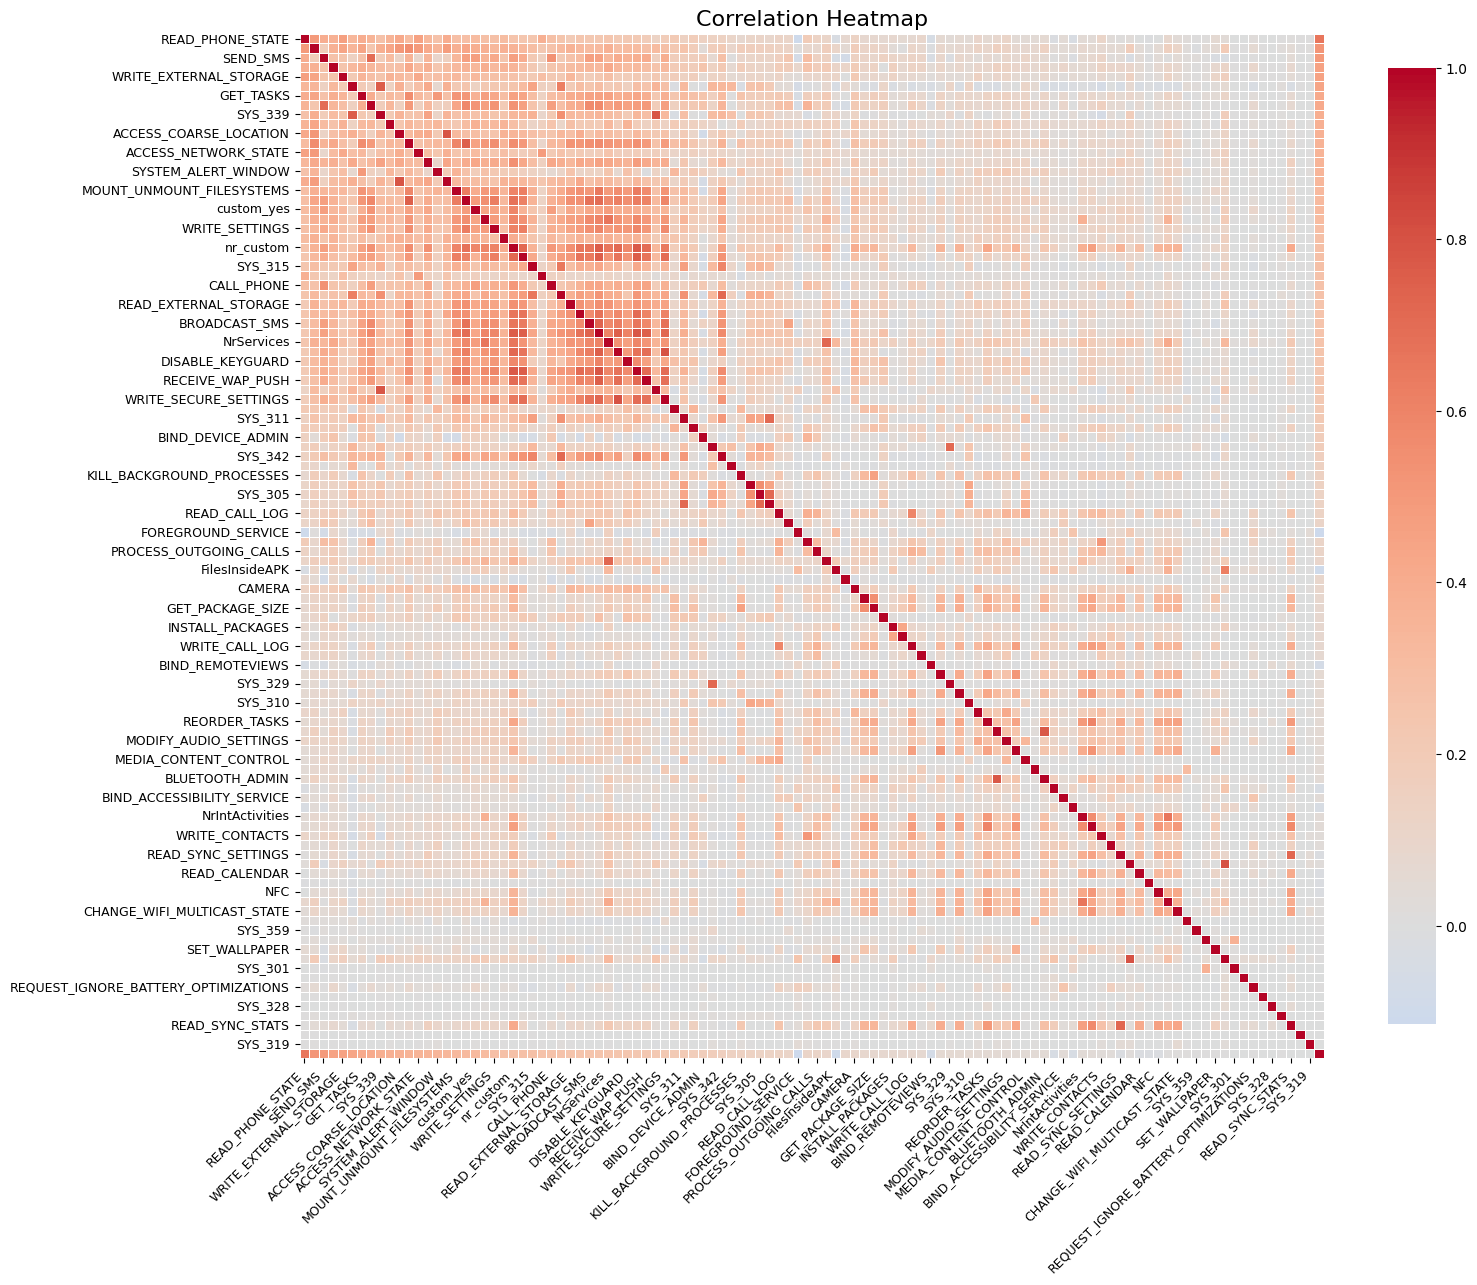


Testing: Logistic Regression

--- RESULTS ---
Accuracy:  93.66%
Precision: 95.14%
Recall:    92.72%
F1-Score:  93.92%


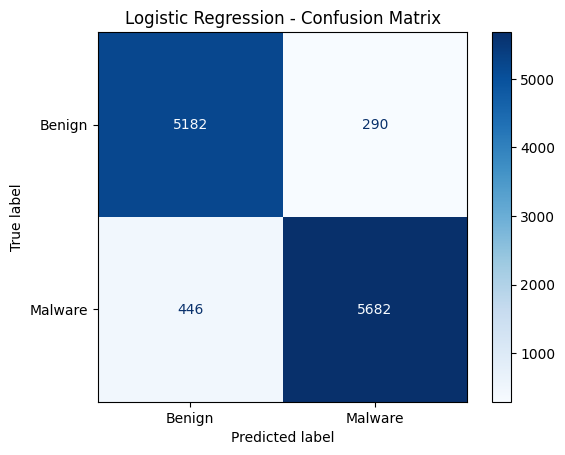


Testing: Random Forest

--- RESULTS ---
Accuracy:  97.95%
Precision: 98.36%
Recall:    97.75%
F1-Score:  98.05%


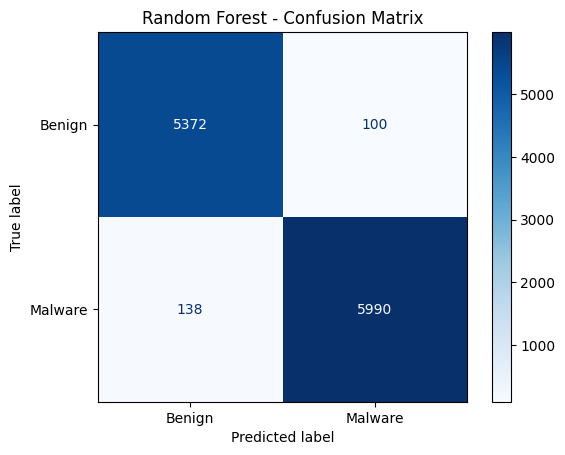


Testing: XGBoost

--- RESULTS ---
Accuracy:  98.18%
Precision: 98.49%
Recall:    98.06%
F1-Score:  98.27%


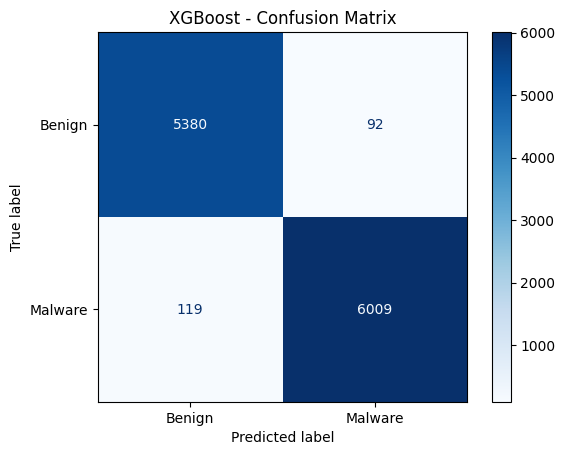


Testing: LightGBM

--- RESULTS ---
Accuracy:  98.42%
Precision: 98.83%
Recall:    98.17%
F1-Score:  98.50%


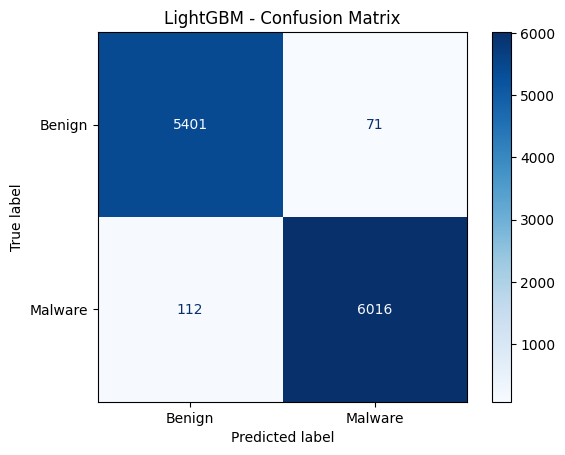


Testing: SVM

--- RESULTS ---
Accuracy:  97.34%
Precision: 97.47%
Recall:    97.50%
F1-Score:  97.49%


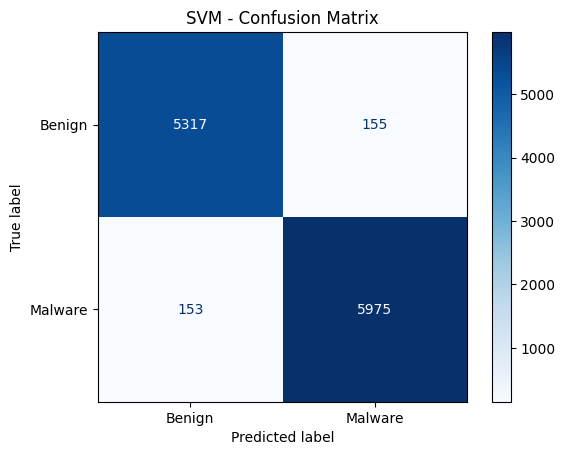


Testing: AdaBoost

--- RESULTS ---
Accuracy:  94.34%
Precision: 95.07%
Recall:    94.17%
F1-Score:  94.62%


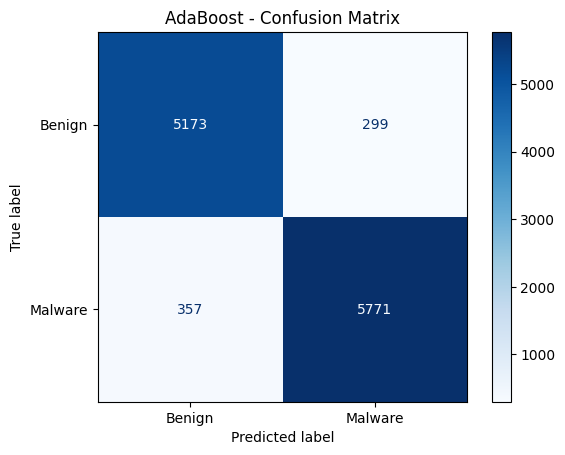


Testing: Neural Network

--- RESULTS ---
Accuracy:  97.54%
Precision: 98.00%
Recall:    97.34%
F1-Score:  97.67%


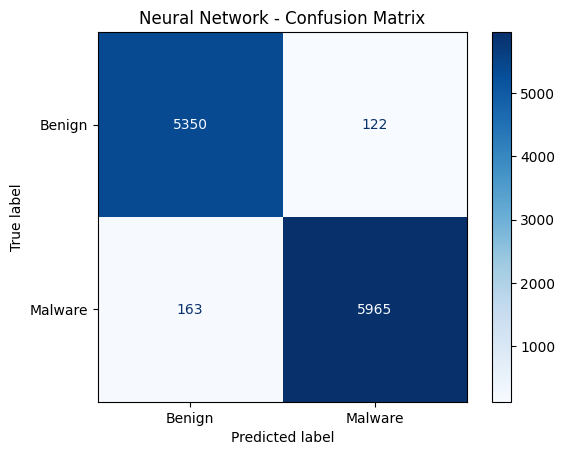


MODEL COMPARISON
Model                  Accuracy     Precision    Recall       F1-Score    
----------------------------------------------------------------------
Logistic Regression         93.66%      95.14%      92.72%      93.92%
Random Forest               97.95%      98.36%      97.75%      98.05%
XGBoost                     98.18%      98.49%      98.06%      98.27%
LightGBM                    98.42%      98.83%      98.17%      98.50%
SVM                         97.34%      97.47%      97.50%      97.49%
AdaBoost                    94.34%      95.07%      94.17%      94.62%
Neural Network              97.54%      98.00%      97.34%      97.67%


In [4]:
# Skup podataka
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from binary_model import find_useful_columns, remove_correlated_features, show_data, RANDOM_STATE, load_and_test_models
from data_processing import PATH_TO_SAVE_STATIC
import pandas as pd


df = pd.read_csv(PATH_TO_SAVE_STATIC)

x = df.drop(['Malware'], axis=1)
y = df['Malware']

# Uklanjamo kolone koje imaju jaku koleraciju sa total_permissions (Ovo je kako sam prvo ručno uklonila kolone, ovo kod automatksi radi)
x = x.drop(['nr_permissions', 'normal', 'dangerous'], axis=1)

# Raspodela podataka
print(df['Malware'].value_counts())
#     Malware
# 1    40850
# 0    36480
# Ovde vidimo da je skup podataka ima podelu skoro 50/50.

show_data(x, y, 'Malware')

# Uklanjamo podatke koji su visoko korelisani
x = remove_correlated_features(x, threshold=0.8)

# Delimo podatke na 70%/15%/15% 
x_train, validation_x, y_train, validation_y = train_test_split(x, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y, shuffle=True) # IMPORTANT: We need to shuffle the data

# Delimo poslednjih 30% na validacioni i test skup
x_val, x_test, y_val, y_test = train_test_split(validation_x, validation_y, test_size=0.5, random_state=RANDOM_STATE, stratify=validation_y)

binary_cols = [c for c in x.columns if set(x[c].unique()) <= {0, 1}]
numeric_cols = [c for c in x.columns if c not in binary_cols]

# Skaliramo podatke (samo numeričke kolone)
scaler = StandardScaler()
x_train[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])
x_val[numeric_cols] = scaler.transform(x_val[numeric_cols])
x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])

# Funkcija za izbacivanje kolona čije vrednost nemaju statističku važnost
x_train, x_val, x_test = find_useful_columns(x_train, x_val, x_test, binary_cols, numeric_cols)

show_data(x_train, y_train, 'Malware')

# PCA
# x_train, x_val, x_test = apply_pca(x, x_train, x_val, x_test)

# Automatsko podešavanje hiperparametara 
# tune_all_models(x_train, y_train)

# Treniranje modela i evaluacija
# model_results = train_and_evaluate_models(x_train, y_train, x_val, y_val) # Ovo koristimo da treniramo model

# Učitavanje i testiranje pretreniranih modela
model_results = load_and_test_models(x_test=x_test, y_test=y_test, SHOW_GRAPS=True)

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(f"{'Model':<22} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*70)
for name, acc, prec, rec, f1 in model_results:
    print(f"{name:<22} {acc:>10.2f}% {prec:>10.2f}% {rec:>10.2f}% {f1:>10.2f}%")

Ovde vidimo da se `LightGBM` pokazao kao najbolji model za binarnu klasifikaciju. Korićen je F1-Score tokom treniranja za evaluaciju modela. 

Modeli imaju korektnu matricu korelacije i rezultati testiranja su veoma blizu validacionim rezultatima.

Ovde nije korišćen model `TabNet`.

### Primer koda - testiranje pretreniranih modela za klasifikaciju familija

Number of classes after grouping: 36
Correlation with MalFamily:
RECEIVE_MMS                    0.453648
BROADCAST_STICKY               0.452597
MOUNT_UNMOUNT_FILESYSTEMS      0.440167
WRITE_SECURE_SETTINGS          0.405325
WRITE_APN_SETTINGS             0.400745
                                 ...   
LOCATION_HARDWARE                   NaN
QUERY_ALL_PACKAGES                  NaN
READ_PRECISE_PHONE_STATE            NaN
REQUEST_PASSWORD_COMPLEXITY         NaN
USE_BIOMETRIC                       NaN
Name: MalFamily, Length: 292, dtype: float64


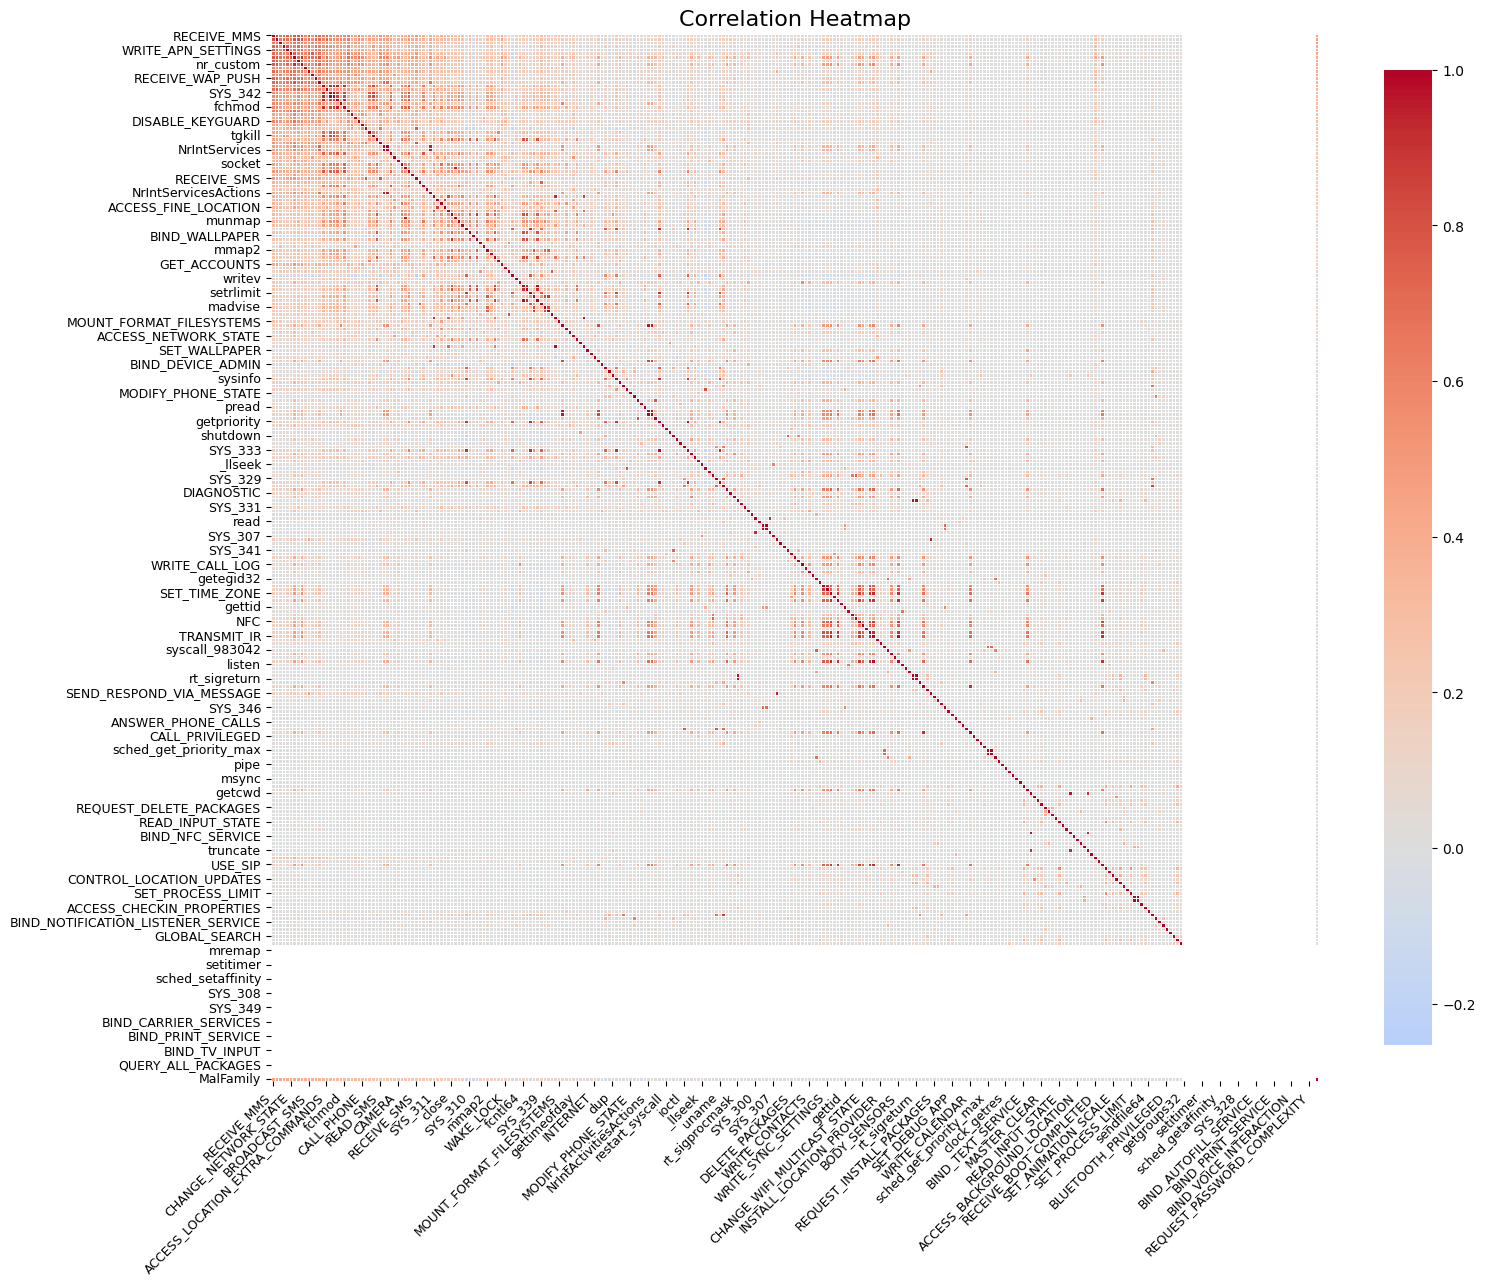


Removing 15 highly correlated features (threshold=0.95):
['munlock', 'fcntl64', 'getcwd', 'sched_getparam', 'sched_get_priority_min', 'rt_sigreturn', 'pwrite', 'SYS_312', 'SYS_333', 'SYS_342', 'SYS_359', 'TRANSMIT_IR', 'NrIntActivitiesActions', 'NrIntReceivers', 'TotalIntentFilters']
Remaining features: 277
Training set size: 40850 apps
Feature threshold: 202 apps (0.49% margin of error)
Binary cols dropped: 99
Numeric cols dropped: 21
Total num of features dropped: 120
New shape: (40850, 157)
Correlation with MalFamily:
RECEIVE_MMS                  0.453648
BROADCAST_STICKY             0.452597
MOUNT_UNMOUNT_FILESYSTEMS    0.440167
WRITE_SECURE_SETTINGS        0.405325
WRITE_APN_SETTINGS           0.400745
                               ...   
USE_SIP                      0.003201
ptrace                       0.002143
clock_gettime                0.001506
getsockname                  0.001304
connect                      0.001086
Name: MalFamily, Length: 157, dtype: float64


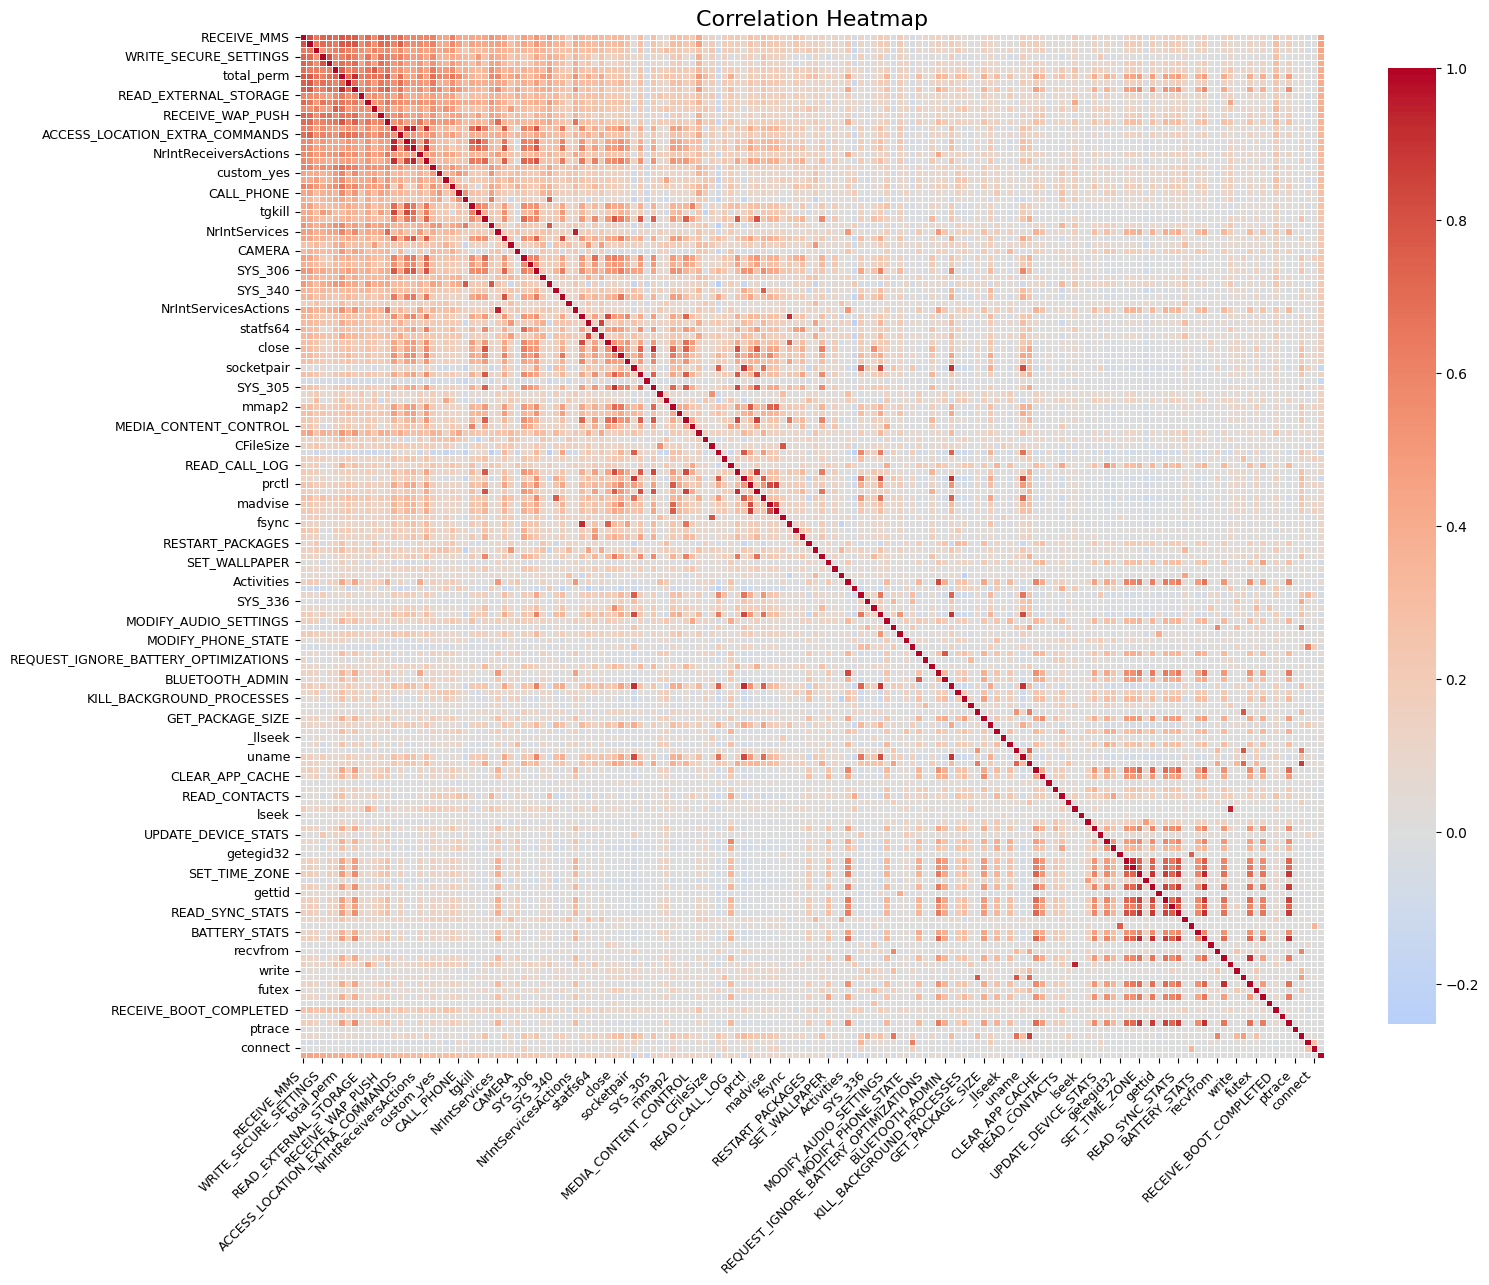


Testing: Logistic Regression

--- RESULTS ---
Accuracy:  74.80%
Precision: 73.43%
Recall:    74.80%
F1-Score:  73.56%


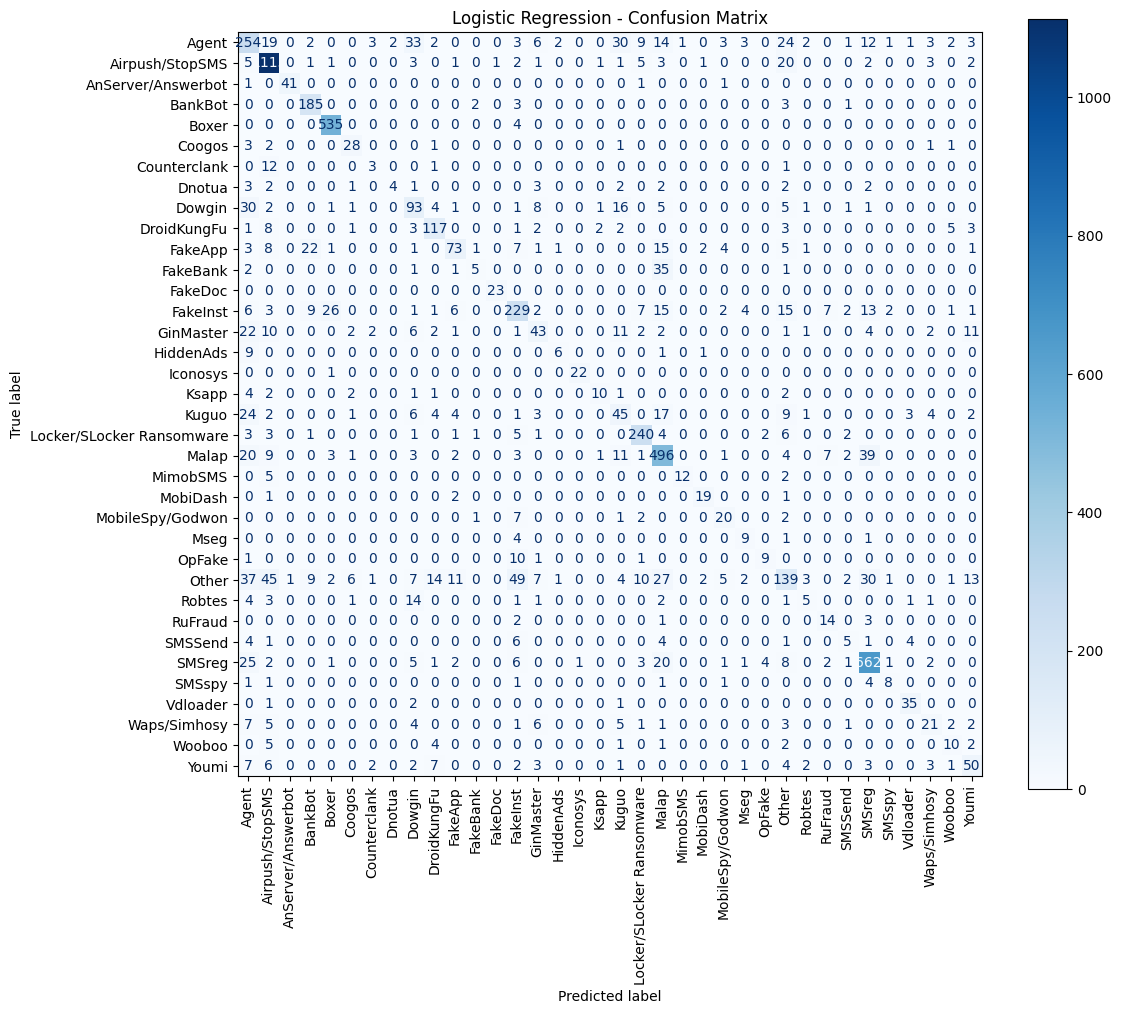


Testing: Random Forest

--- RESULTS ---
Accuracy:  85.10%
Precision: 85.23%
Recall:    85.10%
F1-Score:  84.52%


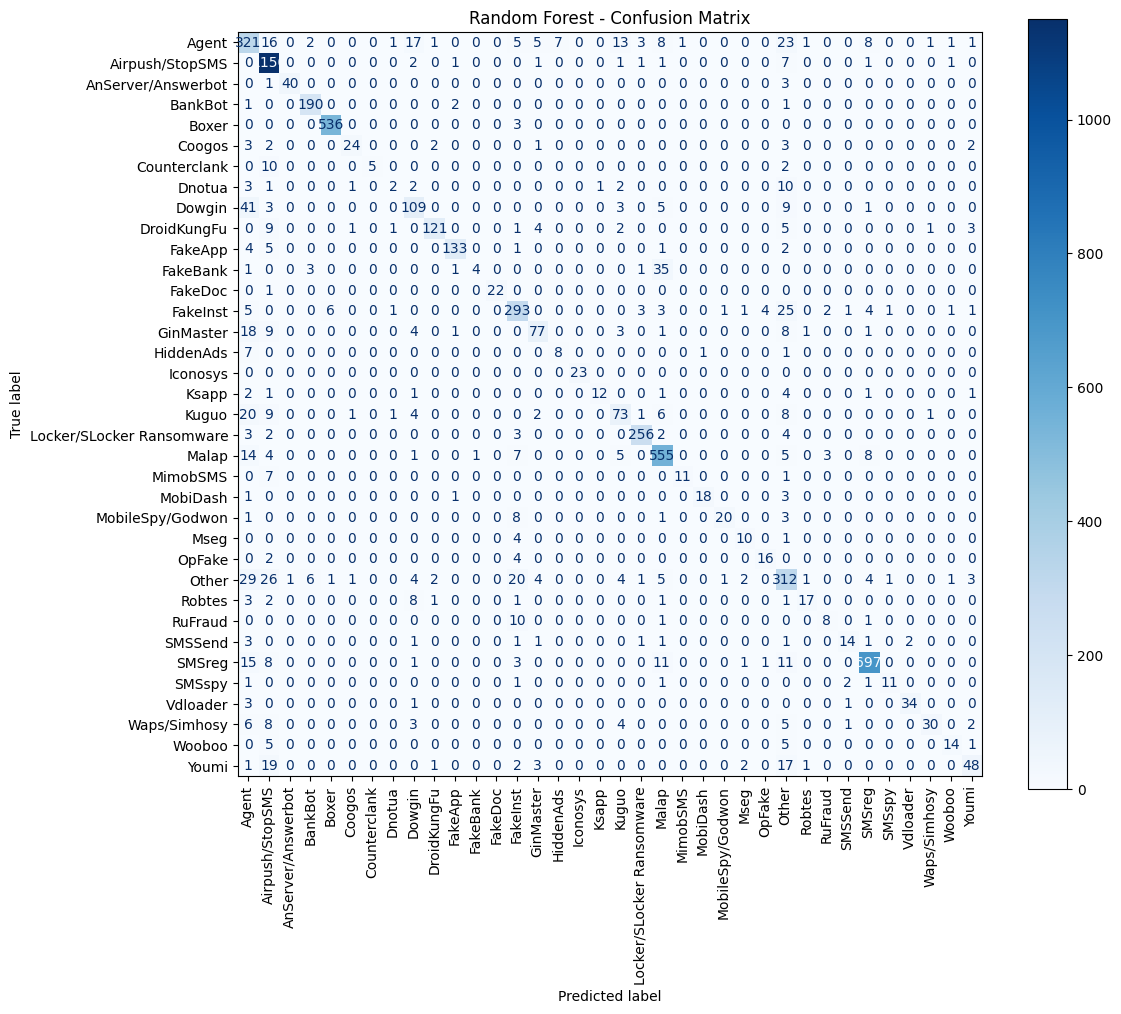


Testing: XGBoost

--- RESULTS ---
Accuracy:  85.54%
Precision: 85.66%
Recall:    85.54%
F1-Score:  85.32%


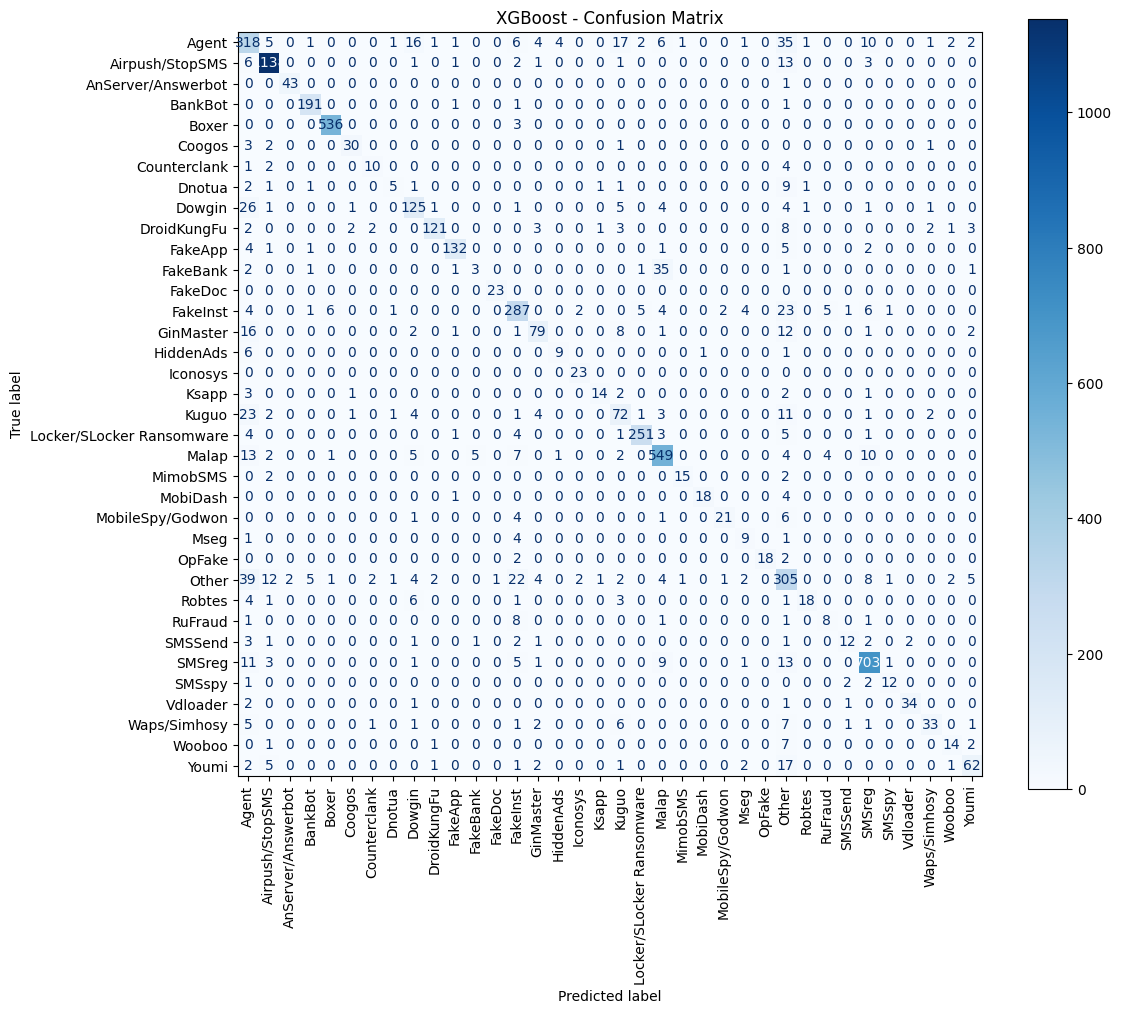


Testing: LightGBM

--- RESULTS ---
Accuracy:  86.14%
Precision: 86.50%
Recall:    86.14%
F1-Score:  86.13%


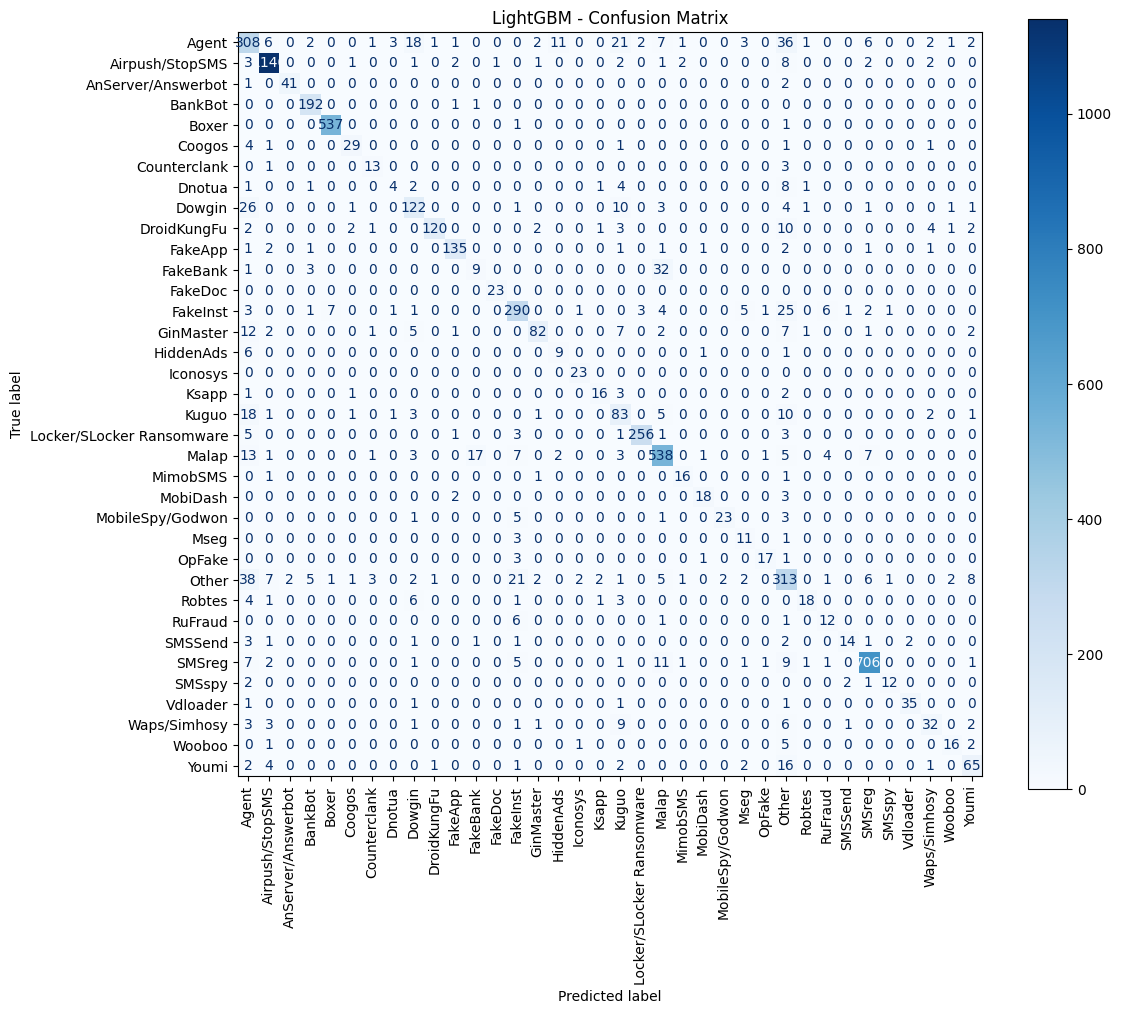


Testing: SVM

--- RESULTS ---
Accuracy:  83.14%
Precision: 83.07%
Recall:    83.14%
F1-Score:  82.87%


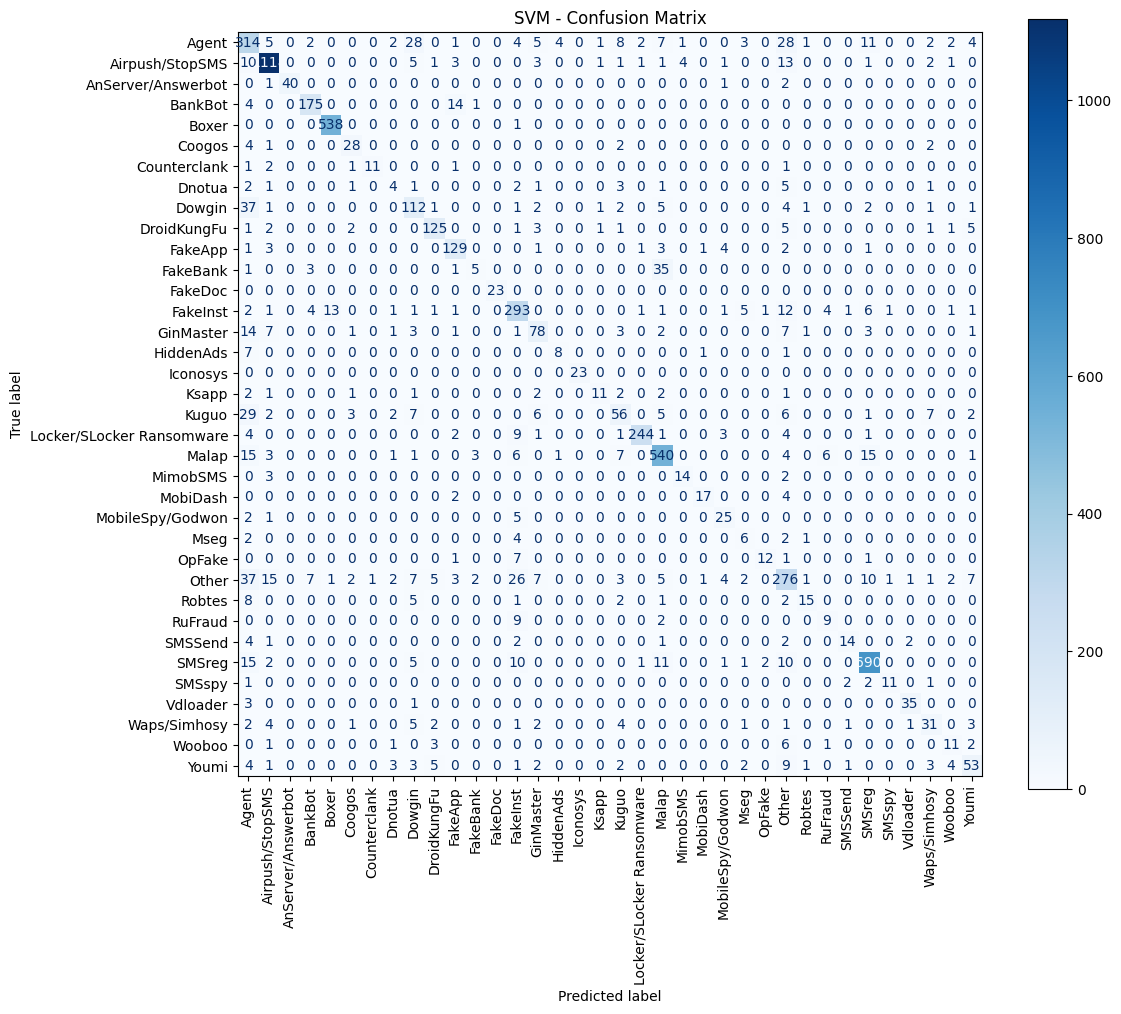


Testing: AdaBoost


c:\Users\emili\Documents\Projects\Malware Clasification AI\Detection-and-Classification-of-Malicious-Android-Applications\malware_detection_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



--- RESULTS ---
Accuracy:  62.85%
Precision: 63.91%
Recall:    62.85%
F1-Score:  61.95%


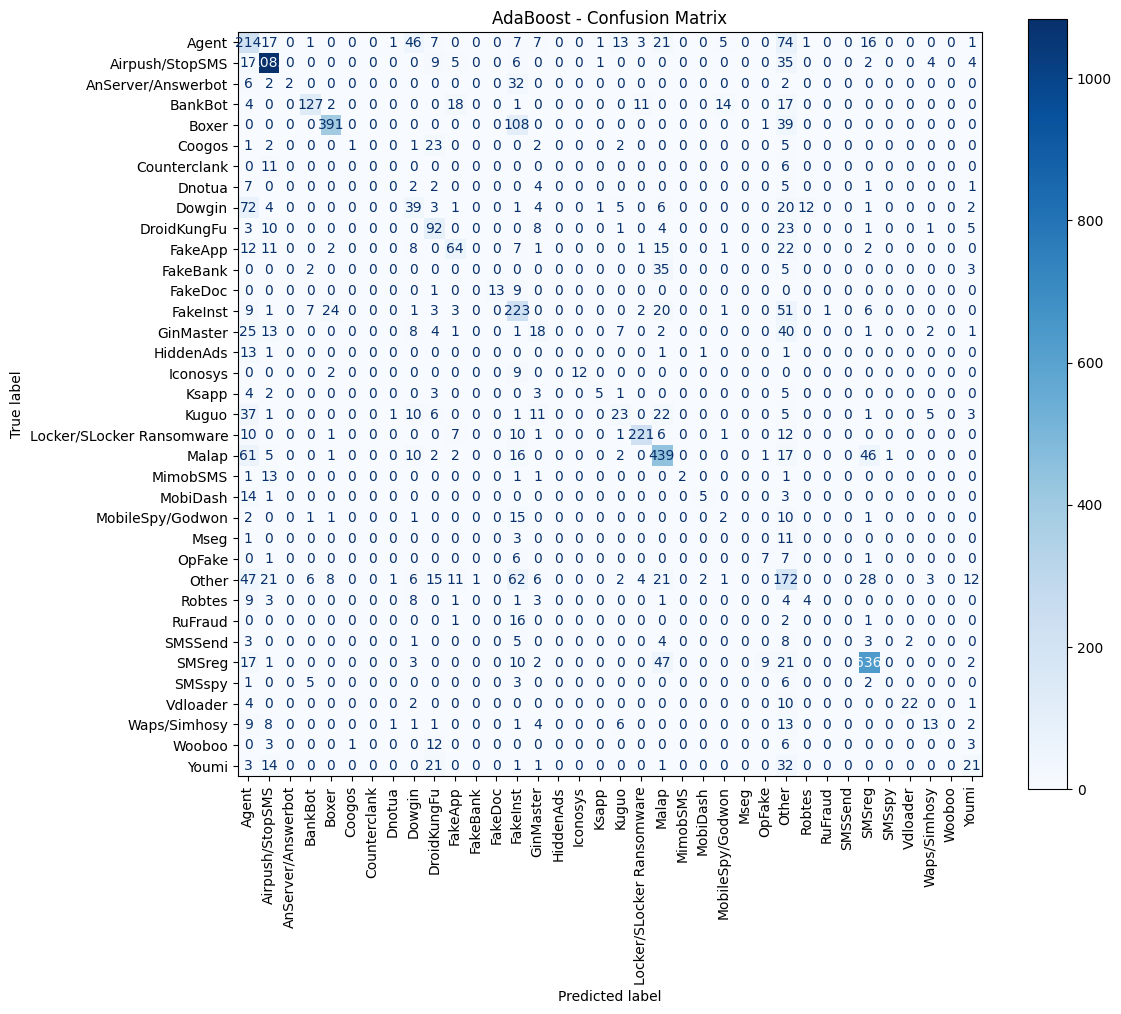


Testing: TabNet

--- RESULTS ---
Accuracy:  81.36%
Precision: 81.35%
Recall:    81.36%
F1-Score:  80.87%


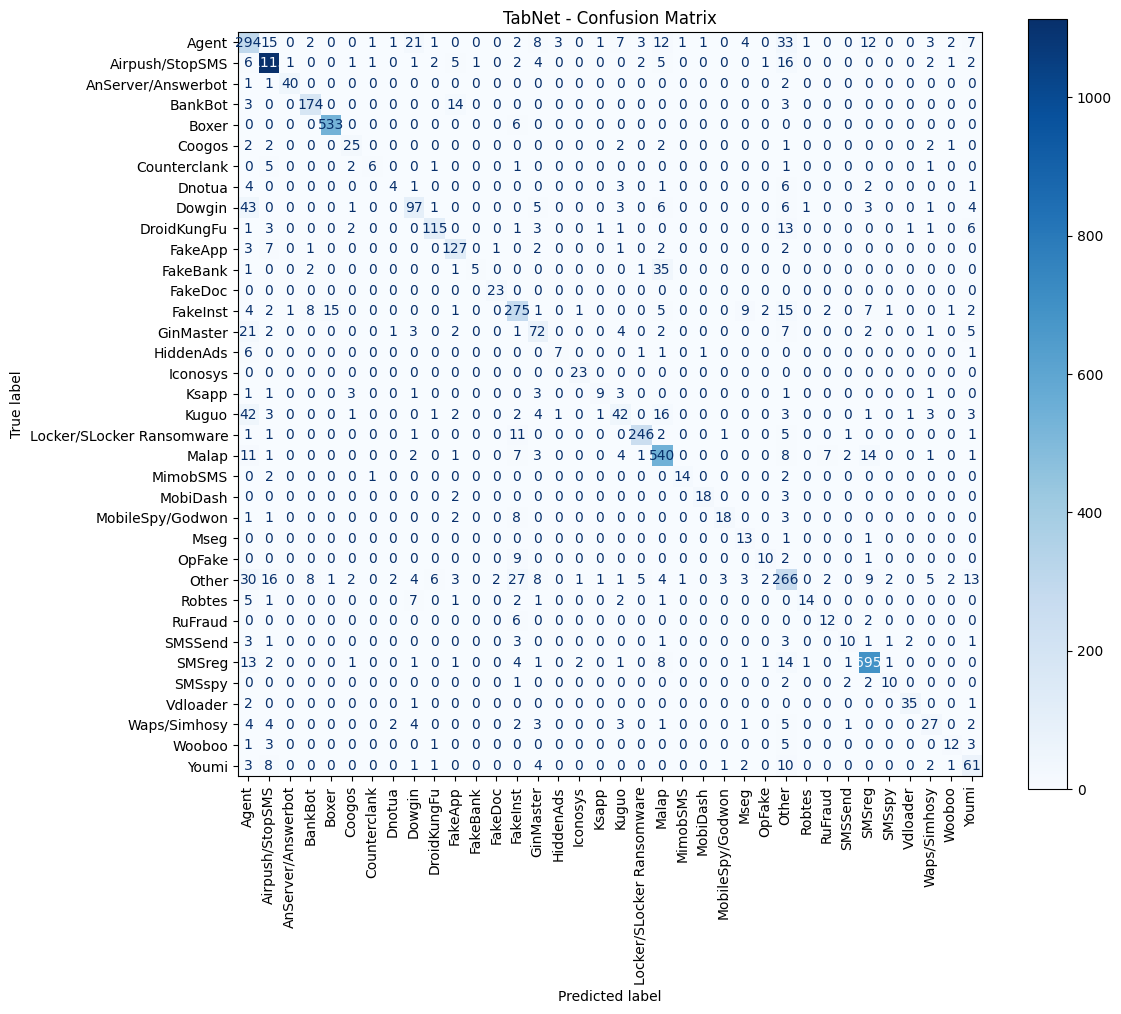


MODEL COMPARISON
Model                  Accuracy     Precision    Recall       F1-Score    
----------------------------------------------------------------------
Logistic Regression         74.80%      73.43%      74.80%      73.56%
Random Forest               85.10%      85.23%      85.10%      84.52%
XGBoost                     85.54%      85.66%      85.54%      85.32%
LightGBM                    86.14%      86.50%      86.14%      86.13%
SVM                         83.14%      83.07%      83.14%      82.87%
AdaBoost                    62.85%      63.91%      62.85%      61.95%
TabNet                      81.36%      81.35%      81.36%      80.87%


In [6]:
from classification_model import RANDOM_STATE, find_useful_columns, show_data, load_and_test_models, train_and_evaluate_models, apply_pca
from data_processing import PATH_TO_SAVE_DYNAMIC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(PATH_TO_SAVE_DYNAMIC).drop(['nr_permissions', 'normal', 'dangerous'], axis=1)

# Filter koji zadržava samo maliciozne uzorke
df = df[df['Malware'] == 1]

# Grupisanje malicioznih uzoraka po familijama, gde se familije sa manje od 100 uzoraka grupišu pod 'Other'
family_counts = df['MalFamily'].value_counts()
df['MalFamily'] = df['MalFamily'].where(df['MalFamily'].map(family_counts) >= 100, 'Other')
print(f"Number of classes after grouping: {df['MalFamily'].nunique()}")

le = LabelEncoder()
x = df.drop(['MalFamily', 'Malware'], axis=1)
y = df['MalFamily']
y_encoded = le.fit_transform(y)

show_data(x, y_encoded, 'MalFamily')

x = remove_correlated_features(x, threshold=0.95)

binary_cols = [c for c in x.columns if set(x[c].unique()) <= {0, 1}]
numeric_cols = [c for c in x.columns if c not in binary_cols]

# Uklanjamo podatke koji su visoko korelisani
x = find_useful_columns(x, binary_cols, numeric_cols)

# Prikaz matrice korelacije
show_data(x, y_encoded, 'MalFamily')

# Delimo podatke na 70%/15%/15% 
x_train, validation_x, y_train, validation_y = train_test_split(x, y_encoded, test_size=0.3, random_state=RANDOM_STATE, stratify=y_encoded, shuffle=True) # IMPORTANT: We need to shuffle the data

#  Delimo poslednjih 30% na validacioni i test skup
x_val, x_test, y_val, y_test = train_test_split(validation_x, validation_y, test_size=0.5, random_state=RANDOM_STATE, stratify=validation_y, shuffle=True)

# Ponovno određivanje binarnih i numeričkih kolona
binary_cols = [c for c in x.columns if set(x[c].unique()) <= {0, 1}]
numeric_cols = [c for c in x.columns if c not in binary_cols]

# Skaliramo podatke (samo numeričke kolone)
scaler = StandardScaler()
x_train[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])
x_val[numeric_cols] = scaler.transform(x_val[numeric_cols])
x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])

# PCA
# x_train, x_val, x_test = apply_pca(x, x_train, x_val, x_test)

# Treniranje modela i evaluacija
# model_results = train_and_evaluate_models(x_train, y_train, x_val, y_val, labels=le.classes_)

# Automatsko podešavanje hiperparametara 
# tune_all_models(x_train, y_train)

# Učitavanje i testiranje pretreniranih modela
model_results = load_and_test_models(x_val, y_val, labels=le.classes_, SHOW_GRAPS=True)

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(f"{'Model':<22} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*70)
for name, acc, prec, rec, f1 in model_results:
    print(f"{name:<22} {acc:>10.2f}% {prec:>10.2f}% {rec:>10.2f}% {f1:>10.2f}%")

Takođe `LightGBM` ovde daje najbolje rezultate sa F1-scorom od `86.13%`. 

Ovde se može videti da idalje postoji jakih korelacija u korelacionoj matrici. Međutim, smanjenje broja ovih korelacija nije doprinelo performansama modele, niti je značajno uticalo na vreme treniranja. 

F1-score od `86.13%` je prihvatljih, ali nije idealan. Međutim, uzimanjem u obzir broj malicioznih familija i broj podataka, ovaj rezultat je zadovoljavajuć.

Pokušano je korišćenje SMOTE i balansiranja podataka, ali nije imalo pozitivnog uticaja na performanse.

Ovde nije korišćen `MLP` iz razloga što je zahtevao jako puno vremena da bi se model istrenirao.

## Zaključak

Kod oba modela, korišćenje PCA se nije pokazalo značajnim, čak su se i negde izgubile performanse. <br>
Iz ovog razloga se i kod `Fly` i `Dragon` modela koristi funkcija `find_useful_columns` za uklanjanje atributa koji nisu statistički značajni. <br>
Takođe se vrši i skaliranje podataka.

Kod oba modela je korišćena funkcija `tune_all_models` da bi se isporbao veliki broj potencijalnih hiperparametara. Ova funkcija koristi `GridSearchCV` funkciju da bi isprobala sve zadate parametre. <br>
Posle dobijanja rezultata ove funkcije, modeli su podešavani ručno da bi se dobio što veći `F1-score`.  

### Primer hiperparametara modela

#### Fly (binarni) model

In [ ]:
[LogisticRegression(random_state=RANDOM_STATE, max_iter=10000, C=0.1, penalty='l2', solver='lbfgs'), "Logistic Regression"], # Increasing the max_iter above 10000 does not improve the results much
[RandomForestClassifier(n_estimators=120, random_state=RANDOM_STATE, max_depth=30, min_samples_split=2, min_samples_leaf=1), "Random Forest"],
[xgb.XGBClassifier(objective="binary:logistic", random_state=RANDOM_STATE, colsample_bytree=0.3, learning_rate=0.3, max_depth=9, n_estimators=300), "XGBoost"],
[lgb.LGBMClassifier(random_state=RANDOM_STATE, learning_rate=0.3, max_depth=-1, n_estimators=400, num_leaves=100, verbose=-1), "LightGBM"],
[SVM(kernel='rbf', random_state=RANDOM_STATE, C=10, gamma=0.1, probability=False), "Support Vector Machine"],
[AdaBoostClassifier(n_estimators=200, random_state=RANDOM_STATE, learning_rate=1), "AdaBoost"],
[MLPClassifier(hidden_layer_sizes=(200, 150, 75), max_iter=100, random_state=RANDOM_STATE, alpha=0.00085, activation='relu', early_stopping=True), "Neural Network"],


#### Dragon (klasifikacioni) model 


In [ ]:
[LogisticRegression(random_state=RANDOM_STATE, max_iter=10000, C=52, penalty='l2', multi_class='ovr'), "Logistic Regression"],
[RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=120), "Random Forest"], 
[xgb.XGBClassifier(objective="multi:softmax", random_state=RANDOM_STATE), "XGBoost"], 
[lgb.LGBMClassifier(random_state=RANDOM_STATE, objective='multiclass', num_class=36, class_weight='balanced', num_leaves=64, max_depth=9, n_estimators=400, learning_rate=0.095,  verbose=-1), "LightGBM"],
[SVM(kernel='rbf', random_state=RANDOM_STATE, decision_function_shape='ovr', C=250, gamma='scale', probability=False), "Support Vector Machine"], 
[AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE), n_estimators=200, learning_rate=0.5, random_state=RANDOM_STATE), "AdaBoost"],
[TabNetClassifier(verbose=0, seed=RANDOM_STATE, n_d=32, n_a=32, n_steps=3), "TabNet"]